# 09-01 워드 임베딩(Word Embedding)

## 09-03 영어/한국어 Word2Vec 실습

### 1. 영어 Word2Vec 만들기

In [4]:
# gensim 패키지에서 지원

import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

#### 1) 훈련 데이터 이해하기

In [5]:
# 훈련 데이터 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x2414aa7d6f0>)

훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 
얻기 위해서 전처리 필요하다
영어 문장으로만 구성된 <content>와 </content> 사이의 내용 필요
xml 문법들 제거, 배경음 나타내는 단어도 제거.

#### 2) 훈련 데이터 전처리

In [6]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [7]:
# 샘플 3개만 출력
# 토큰화 수행 되었음을 확인
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### Word2Vec 훈련시키기

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

Word2Vec의 하이퍼파라미터 값
<br>vector_size(size) = 워드 벡터의 특징 값, 임베딩된 벡터의 차원
<br>window = window 크기
<br>min_count = 단어 최소 빈도수 제한(빈도 적으면 학습 X)
<br>workers = 학습을 위한 프로세스 수
<br>sg = 0은 CBOW, 1은 Skip-gram

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

# man 과 유사한 단어들

[('woman', 0.8288793563842773), ('guy', 0.805503249168396), ('lady', 0.756369411945343), ('boy', 0.7539586424827576), ('gentleman', 0.7482995390892029), ('soldier', 0.7296438813209534), ('girl', 0.7210232019424438), ('rabbi', 0.7059313058853149), ('kid', 0.6826882362365723), ('friend', 0.6637780070304871)]


#### 4) Word2Vec 모델 저장하고 로드

In [10]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

### 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [12]:
# 데이터 다운
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x2418fecd7e0>)

In [13]:
# 영화 리뷰를 데이터 프레임으로 로드, 상위 5개 출력
train_data = pd.read_table('ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [14]:
# 총 리뷰 개수
print(len(train_data)) # 리뷰 개수 출력

200000


In [15]:
# NULL 값(결측값) 존재 유무
print(train_data.isnull().values.any())

True


In [16]:
# 결측값 행 제거

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [18]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\junha\AppData\Local\Temp\ipykernel_24848\2342004949.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [19]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [27]:
!pip install tqdm
from tqdm import tqdm

In [28]:
# 학습시에 사용 안 하는 불용어 제거.

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [10:08<00:00, 328.85it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


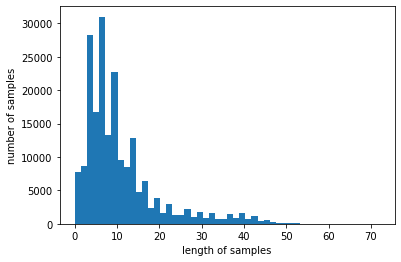

In [59]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [60]:
# Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [61]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

# 16477개의 단어와 100차원으로 구성

(16477, 100)

In [63]:
print(model.wv.most_similar("주먹"))

[('미사일', 0.7664713859558105), ('몰래', 0.7634122371673584), ('갈기', 0.7627801895141602), ('방귀', 0.7626407742500305), ('팽이', 0.7592847347259521), ('첩', 0.7583670020103455), ('군생활', 0.7571579217910767), ('싸대기', 0.7550042271614075), ('댕기', 0.754547655582428), ('후려', 0.7533392310142517)]


In [33]:
print(model.wv.most_similar("팝콘"))

[('과자', 0.7422270178794861), ('햄버거', 0.7309072017669678), ('자장면', 0.7188080549240112), ('소문나다', 0.7062036395072937), ('끓이다', 0.7045331001281738), ('칠하다', 0.701140820980072), ('워터', 0.6994909048080444), ('고기', 0.6994893550872803), ('돼지고기', 0.6956853866577148), ('게뭐임', 0.6915823221206665)]


### 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

In [34]:
# 구글이 제공하는 사전 훈련된 Word2Vec 모델

import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("C:\\Users\\junha\\OneDrive\\바탕 화면\\대학\\산학\\실습폴더\\GoogleNews-vectors-negative300.bin.gz", binary=True)


In [35]:
#모델의 크기
print(word2vec_model.vectors.shape)

(3000000, 300)


In [36]:
# 사전 훈련된 임베딩 사용해서 두 단어의 유사도 계산

print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [37]:
# book의 벡터 출력
print(word2vec_model['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

## 09-04 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)

### 3. 20뉴스그룹 데이터 전처리하기

In [65]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [66]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [67]:
# 전처리 진행
# 불필요한 토큰 제거, 소문자화 통해 정규화 진행

news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\junha\AppData\Local\Temp\ipykernel_24848\1497317567.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [68]:
news_df.isnull().values.any()
# Null 값 있는지 확인

False

In [69]:
# Null이 없어도 empty도 확인 해야한다.
# 모든 빈 값을 NULL로 변환, 이후 다시 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [70]:
# Null값 제거

news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [71]:
# 불용어를 제거

stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [72]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\Python310\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [73]:
# 정수 인코딩 진행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [74]:
# 상위 2개 출력
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [75]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 4. 네거티브 샘플링을 통한 데이터셋 구성하기

In [76]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [77]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(holocaust (2669), blessing (10669)) -> 1
(media (702), least (87)) -> 1
(think (6), seem (207)) -> 1
(media (702), franco (18632)) -> 0
(atrocities (4406), extraordinarily (36861)) -> 0


In [78]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [79]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


### 5. Skip-Gram with Negative Sampling(SGNS) 구현

In [80]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [81]:
## 하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가합니다.

embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

In [82]:
# 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이다
# 임베딩 테이블 거쳐서 내적 수행, 결과 1 또는 0을 예측하기 위해서 시그모이드 함수 사용

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       6427700     ['input_4[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       6427700     ['input_5[0][0]']                
                                                                                            

In [83]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 6.931220531463623
Epoch : 2 Loss : 6.906664192676544
Epoch : 3 Loss : 6.881095290184021
Epoch : 4 Loss : 6.850701093673706
Epoch : 5 Loss : 6.81300151348114


### 6. 결과 확인하기

In [87]:
# 학습된 모델의 결과 확인
# 학습된 임베딩 벡터들을 vector.txt에 저장
# 이후 로드하면 쉽게 단어 벡터 간 유사도 구하기 가능

import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [89]:
w2v.most_similar(positive=['croissant'])

# 크로아상과는 유사한 단어가 없으므로 에러가 뜬다

KeyError: "Key 'croissant' not present in vocabulary"

In [90]:
w2v.most_similar(positive=['tank'])

[('phoenix', 0.3944973647594452),
 ('commerce', 0.38503366708755493),
 ('ramsey', 0.38390958309173584),
 ('duffey', 0.38384494185447693),
 ('hermodorus', 0.3832109272480011),
 ('typhoid', 0.3690224587917328),
 ('coups', 0.36359933018684387),
 ('rvdu', 0.3573727011680603),
 ('textedit', 0.35519111156463623),
 ('medigue', 0.35296517610549927)]

## 09-05 글로브(GloVe)

해당 글로브 패키지가 존재하지 않으므로 Skip

In [101]:
# GloVe 패키지 설치
!pip install glove-python

  Using cached glove_python-0.1.0.tar.gz (263 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for glove-python
Failed to build glove-python


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [86 lines of output]
  C:\Python310\lib\site-packages\setuptools\dist.py:717: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
    warnings.warn(
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.10
  creating build\lib.win-amd64-3.10\glove
  copying glove\corpus.py -> build\lib.win-amd64-3.10\glove
  copying glove\glove.py -> build\lib.win-amd64-3.10\glove
  copying glove\__init__.py -> build\lib.win-amd64-3.10\glove
  running build_ext
  building 'glove.glove_cython' extension
  creating build\temp.win-amd64-3.10
  creating build\temp.win-amd64-3.10\Release
  creating build\temp.win-amd64-3.10\Release\glove
  C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.32.31326\bin\HostX86\x64\cl

## 09-08 사전 훈련된 워드 임베딩(Pre-trained Word Embedding)

### 1. 케라스 임베딩 층(Keras Embedding layer)

#### 1) 임베딩 층은 룩업 테이블이다.

임베딩 층의 입력으로 사용하기 위해 모든 단어들은 정수 인코딩이 되어있어야한다
<br> 임베딩층은 입력 정수에 대해 밀집 벡터로 맵핑한 뒤에 훈련된다.

케라스의 임베딩 층 구현 코드

In [103]:
vocab_size = 20000
output_dim = 128
input_length = 500

v = Embedding(vocab_size, output_dim, input_length=input_length)

vocab_size = 텍스트 데이터의 전체 단어 집합의 크기 <br>
output_dim = 워드 임베딩 후의 임베딩 벡터의 차원 <br>
input_length = 입력 시퀀스의 길이.

#### 2) 임베딩 층 사용하기

긍정, 부정을 판단하는 감성 분류 모델<br>
긍정 문장의 레이블은 1, 부정 문장의 레이블은 0 이다.

In [105]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = ['nice great best amazing', 'stop lies', 'pitiful nerd', 'excellent work', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

토크나이저를 통해서 단어 집합을 만들고, 크기를 확인한다

In [106]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',vocab_size)

단어 집합 : 16


In [107]:
# 정수 인코딩 진행

X_encoded = tokenizer.texts_to_sequences(sentences)
print('정수 인코딩 결과 :',X_encoded)

정수 인코딩 결과 : [[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [108]:
# 가장 긴 문장의 길이를 먼저 구한다

max_len = max(len(l) for l in X_encoded)
print('최대 길이 :',max_len)

# 최대 길이로 모든 샘플에 대해서 패딩 진행
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print('패딩 결과 :')
print(X_train)

최대 길이 : 4
패딩 결과 :
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


훈련 데이터에 대한 전처리는 끝났다.<br>
이진 분류 모델 설계 시작<br>
출력층에 한개의 뉴런, 활성화 함수로는 시그모이드, 손실함수로 binary_crossentropy 사용.

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

embedding_dim = 4

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - loss: 0.7030 - acc: 0.4286 - 1s/epoch - 1s/step
Epoch 2/100
1/1 - 0s - loss: 0.7015 - acc: 0.4286 - 9ms/epoch - 9ms/step
Epoch 3/100
1/1 - 0s - loss: 0.7000 - acc: 0.4286 - 24ms/epoch - 24ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6985 - acc: 0.4286 - 11ms/epoch - 11ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6971 - acc: 0.4286 - 11ms/epoch - 11ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6956 - acc: 0.4286 - 13ms/epoch - 13ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6942 - acc: 0.5714 - 11ms/epoch - 11ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6927 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 9/100
1/1 - 0s - loss: 0.6913 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 10/100
1/1 - 0s - loss: 0.6899 - acc: 0.5714 - 11ms/epoch - 11ms/step
Epoch 11/100
1/1 - 0s - loss: 0.6884 - acc: 0.5714 - 8ms/epoch - 8ms/step
Epoch 12/100
1/1 - 0s - loss: 0.6870 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 13/100
1/1 - 0s - loss: 0.6856 - acc: 0.5714 - 10ms/epoch - 10ms/step
Epoch 14/100
1/1 - 0s - loss: 0.684

### 2. 사전 훈련된 워드 임베딩(Pre-Trained Word Embedding) 사용하기

이전에 사용했던 데이터에 동일한 전처리까지 진행된 상태

In [114]:
print(X_train)
print("-----------------")
print(y_train)

[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]
-----------------
[1 0 0 1 1 0 1]


#### 1) 사전 훈련된 GloVe 사용하기

In [115]:
# glove.6B.zip에서 glove.6B.100d.txt 파일 사용
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

glove 6B.100d.txt에 있는 모든 임베딩 벡터 불러와서 딕셔너리 사용하고 임베딩 벡터의 개수 확인한다

In [116]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8") # 파일 불러오기

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [117]:
# 'respectable'의 임베딩 벡터값과 크기 출력

print(embedding_dict['respectable'])
print('벡터의 차원 수 :',len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

풀고자 하는 문제의 단어 집합 크기의 행, 100개의 열을 가지는 행렬 생성한다, 전부 0으로 채운다 <br>

In [122]:
embedding_matrix = np.zeros((vocab_size, 100))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (16, 100)


기존 데이터의 단어와 맵핑된 정수값 확인

In [123]:
print(tokenizer.word_index.items())

dict_items([('nice', 1), ('great', 2), ('best', 3), ('amazing', 4), ('stop', 5), ('lies', 6), ('pitiful', 7), ('nerd', 8), ('excellent', 9), ('work', 10), ('supreme', 11), ('quality', 12), ('bad', 13), ('highly', 14), ('respectable', 15)])


In [126]:
print('단어 great의 맵핑된 정수 :',tokenizer.word_index['great'])

단어 great의 맵핑된 정수 : 2


In [127]:
# 'great'의 벡터값 확인
print(embedding_dict['great'])

[-0.013786   0.38216    0.53236    0.15261   -0.29694   -0.20558
 -0.41846   -0.58437   -0.77355   -0.87866   -0.37858   -0.18516
 -0.128     -0.20584   -0.22925   -0.42599    0.3725     0.26077
 -1.0702     0.62916   -0.091469   0.70348   -0.4973    -0.77691
  0.66045    0.09465   -0.44893    0.018917   0.33146   -0.35022
 -0.35789    0.030313   0.22253   -0.23236   -0.19719   -0.0053125
 -0.25848    0.58081   -0.10705   -0.17845   -0.16206    0.087086
  0.63029   -0.76649    0.51619    0.14073    1.019     -0.43136
  0.46138   -0.43585   -0.47568    0.19226    0.36065    0.78987
  0.088945  -2.7814    -0.15366    0.01015    1.1798     0.15168
 -0.050112   1.2626    -0.77527    0.36031    0.95761   -0.11385
  0.28035   -0.02591    0.31246   -0.15424    0.3778    -0.13599
  0.2946    -0.31579    0.42943    0.086969   0.019169  -0.27242
 -0.31696    0.37327    0.61997    0.13889    0.17188    0.30363
 -1.2776     0.044423  -0.52736   -0.88536   -0.19428   -0.61947
 -0.10146   -0.26301  

단어 집합의 모든 단어에 대해서 사전 훈련된 GloVe의 임베딩 벡터들을 맵핑

In [128]:
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = embedding_dict.get(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

Embedding layer에 embedding matrix를 초기값으로 설정.<br>
현재 사전 훈련된 워드 임베딩이 100차원을 갖고있기때문에 임베딩 층의 output_dim의 인자값을 100을 주어야한다.
+ 사전 훈련된 워드 임베딩을 그대로 사용, trainable의 인자값 false

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

output_dim = 100

model = Sequential()
e = Embedding(vocab_size, output_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - loss: 0.6829 - acc: 0.5714 - 1s/epoch - 1s/step
Epoch 2/100
1/1 - 0s - loss: 0.6647 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6471 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6301 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6137 - acc: 0.5714 - 10ms/epoch - 10ms/step
Epoch 6/100
1/1 - 0s - loss: 0.5979 - acc: 0.5714 - 6ms/epoch - 6ms/step
Epoch 7/100
1/1 - 0s - loss: 0.5826 - acc: 0.5714 - 8ms/epoch - 8ms/step
Epoch 8/100
1/1 - 0s - loss: 0.5678 - acc: 0.5714 - 7ms/epoch - 7ms/step
Epoch 9/100
1/1 - 0s - loss: 0.5535 - acc: 0.5714 - 9ms/epoch - 9ms/step
Epoch 10/100
1/1 - 0s - loss: 0.5397 - acc: 0.5714 - 7ms/epoch - 7ms/step
Epoch 11/100
1/1 - 0s - loss: 0.5263 - acc: 0.5714 - 7ms/epoch - 7ms/step
Epoch 12/100
1/1 - 0s - loss: 0.5133 - acc: 0.7143 - 7ms/epoch - 7ms/step
Epoch 13/100
1/1 - 0s - loss: 0.5007 - acc: 0.7143 - 7ms/epoch - 7ms/step
Epoch 14/100
1/1 - 0s - loss: 0.4885 - acc: 0.7

#### 2) 사전 훈련된 Word2Vec 사용하기

구글의 사전 훈련된 Word2Vec 모델 로드, word2vec_model에 저장

In [20]:
import gensim

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("C:\\Users\\junha\\OneDrive\\바탕 화면\\대학\\산학\\실습폴더\\GoogleNews-vectors-negative300.bin.gz", binary=True)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인

모델의 크기(shape) : (3000000, 300)


300의 차원을 가진 Word2Vec 벡터가 3,000,000개 존재.<br>

In [133]:
embedding_matrix = np.zeros((vocab_size, 300))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (16, 300)


모든 값이 0으로 채워진 임베딩 행렬<br>
풀고자 하는 문제의 단어 집합 크기의 행(vocab_size)와 300개의 열.<br>

word2vec_model에서 특정 단어를 입력하면 해당 단어의 임베딩 벡터를 리턴, 존재하지 않으면 NULL이 뜨지만 이를 방지하기 위해 None을 리턴하는 get_vector()

In [134]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

단어 집합에서 단어를 1개씩 호출해서 해당 모델에 임베딩 벡터가 존재하는지 확인하고 None이 아니라면 임베딩 행렬에 해당 단어의 인덱스 위치에 임베딩 벡터값을 저장한다.

In [135]:
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

풀고자하는 문제의 16개 단어와 맵핑되는 임베딩 행렬이 완성된다.

In [136]:
print(word2vec_model['nice'])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

In [137]:
print('단어 nice의 맵핑된 정수 :', tokenizer.word_index['nice'])

단어 nice의 맵핑된 정수 : 1


In [138]:
print(embedding_matrix[1])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

임베딩 매트릭스와 모델에서 해당 단어가 맵핑 되었을 때 동일한 것을 확인할 수 있다.

아래에 Embedding에 사전 훈련된 embedding_matrix를 입력으로 넣고 모델을 학습시킨다.

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input

model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - loss: 0.6837 - acc: 0.7143 - 670ms/epoch - 670ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6652 - acc: 0.7143 - 5ms/epoch - 5ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6474 - acc: 0.8571 - 4ms/epoch - 4ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6301 - acc: 0.8571 - 7ms/epoch - 7ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6133 - acc: 0.8571 - 7ms/epoch - 7ms/step
Epoch 6/100
1/1 - 0s - loss: 0.5970 - acc: 0.8571 - 6ms/epoch - 6ms/step
Epoch 7/100
1/1 - 0s - loss: 0.5813 - acc: 1.0000 - 6ms/epoch - 6ms/step
Epoch 8/100
1/1 - 0s - loss: 0.5662 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 9/100
1/1 - 0s - loss: 0.5515 - acc: 1.0000 - 6ms/epoch - 6ms/step
Epoch 10/100
1/1 - 0s - loss: 0.5373 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 11/100
1/1 - 0s - loss: 0.5236 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 12/100
1/1 - 0s - loss: 0.5104 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 13/100
1/1 - 0s - loss: 0.4976 - acc: 1.0000 - 5ms/epoch - 5ms/step
Epoch 14/100
1/1 - 0s - loss: 0.4853 - acc:

## 09-11 문서 벡터를 이용한 추천 시스템(Recommendation System using Document Embedding)

문서 내 단어들을 Word2Vec을 통해 단어 벡터로 변환, 이들의 평균으로 문서 벡터를 얻어 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템 만들기

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

데이터를 데이터 프레임으로 로드.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


문서 총 2382개. 아래는 상위 5개의 행만 출력

In [3]:
df[:5]

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


불필요한 열들이 존재하는데 줄거리에 해당하는 'Desc' 열이 제일 중요하다. 해당 열에 있는 데이터에 대해 Word2Vec을 학습한다.<br>
먼저 해당 열에 대해서 전처리 수행하고 'cleaned'열에 저장한다

In [4]:
# ascii 코드 아닌것들 삭제
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# 다 소문자로
def make_lower_case(text):
    return text.lower()

# 큰 의미를 지니지 않는 단어들 처리. "the" "a ,an" 등
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# HTML 태그 지우기
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# 구두점 정리
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

전처리 후 상위 10개 행 출력

In [5]:
df['cleaned'][:10]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
5    tradition phil knight s shoe dog comes incredi...
6    gregory zuckerman bestselling author greatest ...
7    bestselling writer david graeber powerful argu...
8    aspire lead greater impact problem youre busy ...
9    entrepreneurs often suffer superhero syndromet...
Name: cleaned, dtype: object

전처리 하면서 빈 값이 생긴 행은 nan 값으로 변환하고 해당 행 제거해준다

In [6]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


문서 1개 줄어들었다.

토큰화 수행해서 corpus라는 리스트에 저장

In [7]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())
print(corpus)

[['know', 'power', 'shifting', 'west', 'east', 'north', 'south', 'presidential', 'palaces', 'public', 'squares', 'formidable', 'corporate', 'behemoths', 'nimble', 'startups', 'and', 'slowly', 'surely', 'men', 'women', 'power', 'merely', 'shifting', 'dispersing', 'also', 'decaying', 'power', 'today', 'constrained', 'risk', 'losing', 'ever', 'before', 'end', 'power', 'award', 'winning', 'columnist', 'former', 'foreign', 'policy', 'editor', 'moiss', 'nam', 'illuminates', 'struggle', 'once', 'dominant', 'megaplayers', 'new', 'micropowers', 'challenging', 'every', 'field', 'human', 'endeavor', 'drawing', 'provocative', 'original', 'research', 'nam', 'shows', 'antiestablishment', 'drive', 'micropowers', 'topple', 'tyrants', 'dislodge', 'monopolies', 'open', 'remarkable', 'new', 'opportunities', 'also', 'lead', 'chaos', 'paralysis', 'nam', 'deftly', 'covers', 'seismic', 'changes', 'underway', 'business', 'religion', 'education', 'within', 'families', 'matters', 'war', 'peace', 'examples', 'ab

### 2. 사전 훈련된 워드 임베딩 사용하기

Word2Vec을 처음부터 학습하지 않아도 데이터가 충분하지 않은 상태에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용해서 성능 높이기 가능.<br>
사전 훈련된 Word2Vec 로드하고 초기 단어 벡터값으로 사용한다.

In [8]:
import gensim

word2vec_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers = 2)
word2vec_model.build_vocab(corpus)
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.wv.intersect_word2vec_format("C:\\Users\\junha\\OneDrive\\바탕 화면\\대학\\산학\\실습폴더\\GoogleNews-vectors-negative300.bin.gz", lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(3695265, 3981030)

### 3. 단어 벡터의 평균 구하기

In [13]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [14]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 2381


### 4. 추천 시스템 구현하기

벡터 간의 코사인 유사도 구한다

In [15]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


코사인 유사도를 이용해서 줄거리가 가장 유사한 5개의 책을 찾아내는 함수

In [16]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

좋아하는 책 제목을 입력으로 넣으면 해당 책의 문서 벡터와 유사한 문서 벡터값을 가진 책들 추천.

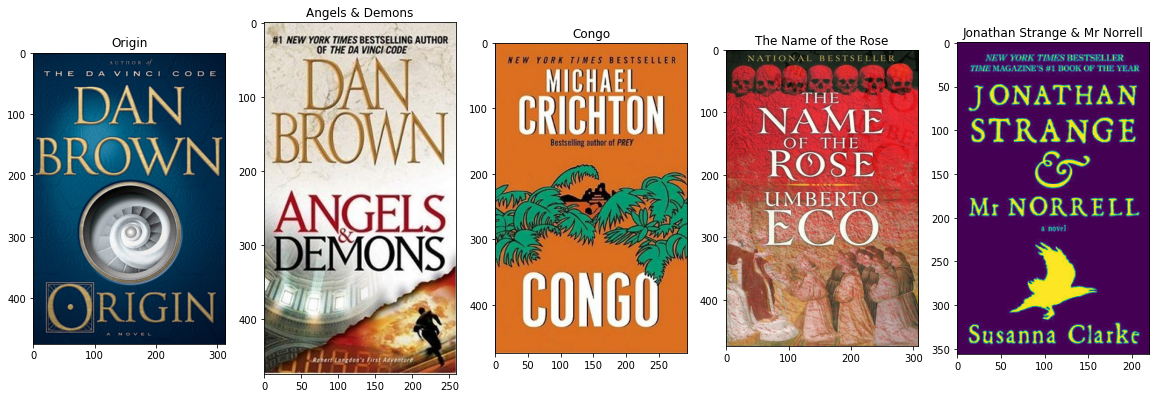

In [17]:
recommendations("The Da Vinci Code")

## 09-12 문서 임베딩: 워드 임베딩의 평균(Average Word Embedding)

### 1. 데이터 로드와 전처리

In [24]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
vocab_size = 20000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 :',len(X_train))
print('테스트용 리뷰 개수 :',len(X_test))

17464789/17464789 [==============================] - 1s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


정수 인코딩까지 전처리 진행되어 있음.

In [28]:
print('훈련 데이터의 첫번째 샘플 :',X_train[0])
print('훈련 데이터의 첫번째 샘플의 레이블 :',y_train[0])

훈련 데이터의 첫번째 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
훈련 데이터의 첫번째 샘플의 레이블 : 1


정수 1이 출력되는데 이는 리뷰가 긍정적임을 의미한다.

각 리뷰의 평균 길이 계산

In [29]:
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, X_test)), dtype=int)))

훈련용 리뷰의 평규 길이: 238
테스트용 리뷰의 평균 길이: 230


크기 400으로 패딩

In [30]:
max_len = 400

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print('X_train의 크기(shape) :', X_train.shape)
print('X_test의 크기(shape) :', X_test.shape)

X_train의 크기(shape) : (25000, 400)
X_test의 크기(shape) : (25000, 400)


### 2. 모델 설계하기

전처리는 완료되었다.<br>
임베딩 벡터를 평균으로 사용하는 모델 설게<br>
GlobalAveragePooling1D()는 입력 벡터들의 평균을 구하는 역할<br>
이진 분류 수행, 시그모이드를 활성화 함수로 사용하는 뉴런 1개.<br>
훈련 데이터 20% 검증 데이터로 사용, 10 에포크 학습

In [31]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))

# 모든 단어 벡터의 평균을 구한다.
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.6281 - acc: 0.7236
Epoch 1: val_acc improved from -inf to 0.80860, saving model to embedding_average_model.h5
625/625 [==============================] - 14s 21ms/step - loss: 0.6281 - acc: 0.7236 - val_loss: 0.5226 - val_acc: 0.8086
Epoch 2/10
623/625 [============================>.] - ETA: 0s - loss: 0.4293 - acc: 0.8556
Epoch 2: val_acc improved from 0.80860 to 0.86640, saving model to embedding_average_model.h5
625/625 [==============================] - 13s 21ms/step - loss: 0.4292 - acc: 0.8556 - val_loss: 0.3814 - val_acc: 0.8664
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.3187 - acc: 0.8906
Epoch 3: val_acc improved from 0.86640 to 0.87940, saving model to embedding_average_model.h5
625/625 [==============================] - 13s 21ms/step - loss: 0.3187 - acc: 0.8906 - val_loss: 0.3233 - val_acc: 0.8794
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.2622 - 

In [32]:
loaded_model = load_model('embedding_average_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 4s 4ms/step - loss: 0.2923 - acc: 0.8870

 테스트 정확도: 0.8870
